<a href="https://colab.research.google.com/github/natbugreal/datascience/blob/main/unit_3_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Unit 3 Project**



In [2]:
  #Definitions in order for my code to run
  !pip install preliz
  import preliz as pz
  import numpy as np
  import matplotlib.pyplot as plt
  import pandas as pd
  import arviz as az
  import pymc as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 8.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 0.6.7.post0 requires scipy!=1.12.0,>=0.13.2, but you have scipy 1.12.0 which is incompatible.


# PRIOR
Throughout this project I will use data from 24 premier league seasons, each value being representative of a fraction of the goals scored by all 20 teams across all season games. With these values, I will create a model for this data and simultaneously determine the true average of goals scored in a premier league season purely from midfielders.

# Context/Why
I chose this fraction of the goals in particular because these numbers are a depiction of the goals scored solely by Midfielders, a position on the team different from forwards, whos priority in the game is to thread passes through the opposing team and create a seamless transition between defense and attackers.

Below, you will see all the goals scored by midfield positions in an array. There are 24 values, each representing a season starting from 1999-2000 all the way to 2023-2024 season. This will be defined as MAGA, not for any reason other than its definition: Midfielder Alliance Goals Average

In [4]:
MAGA = [
  397.5,
  372,
  375.375,
  375,
  379.5,
  365.625,
  360,
  349.125,
  375.75,
  353.25,
  394.875,
  398.625,
  399.75,
  398.625,
  394.5,
  365.625,
  384.75,
  399,
  381.75,
  402,
  387.75,
  384,
  401.625,
  406.5,
]

Im going to start with a uniform prior for the mean and half normal prior for the standard deviation. I believe that half normal for the standard deviation is best because all of my values are above 0, meaning they are positive, This will also limit variation.

(array([2., 1., 2., 1., 3., 2., 3., 2., 5., 3.]),
 array([349.125 , 354.8625, 360.6   , 366.3375, 372.075 , 377.8125,
        383.55  , 389.2875, 395.025 , 400.7625, 406.5   ]),
 <BarContainer object of 10 artists>)

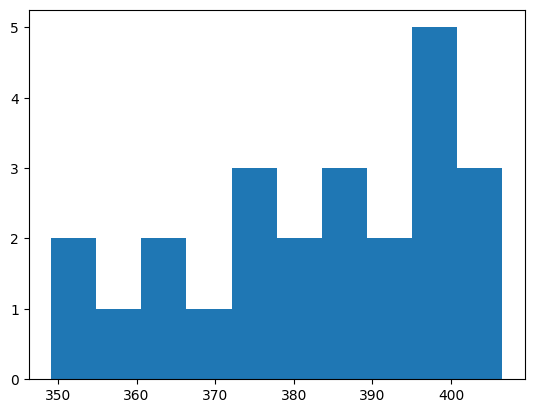

In [5]:
plt.hist(MAGA)

first, I will try a normal model, to see if it fits the likelihood.

In [6]:
with pm.Model() as MidGoals:
    # normal distribution for the mean
    μ = pm.Uniform('μ', lower=350, upper=400)

    #half normal distribution for standard deviation because the standard deviation is all positive and heavier near lower values
    σ = pm.HalfNormal('σ', sigma=5)

    #likelihood
    Y = pm.Normal('Y', mu = μ, sigma = σ, observed=MAGA)
    idata = pm.sample()

Output()

Output()

Output()

<Axes: xlabel='Y'>

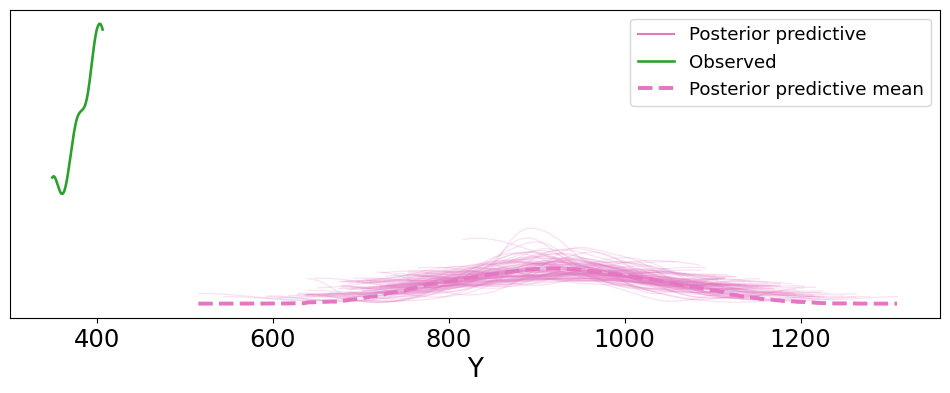

In [ ]:

pm.sample_posterior_predictive(idata, model=MidGoals, extend_inferencedata=True)
az.plot_ppc(idata, num_pp_samples=100, figsize=(12, 4), colors=["C16", "C2", "C16"])

Obviously, having looked at other proper examples of a normal distribitions, my model is not reflective of a suitable match for my dataset, however i have decided to leave in this result to demonstrate the different models i explored before settling on my final product. This clearly did not match the likelihood. Next, i am going to try a Gamma Model because i notice that my data has a skew, Hopefully the gamma model aligns with my data.

In [19]:
#G for Gamma
with pm.Model() as MidGoals:
    #this distribution is centered at 20 with a variation of 5
    #as an estimate of the likelihood data
    μ = pm.Normal('μ', mu=20, sigma=5)

    #5 is used because it is suggested by the textbook
    σ = pm.HalfNormal('σ', sigma=5)

    #creates 2 priors of mu and sigma
    Y = pm.Gamma('Y', mu = μ, sigma = σ, observed=MAGA)
    igammaG = pm.sample()


Output()

Output()

ERROR:pymc.stats.convergence:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

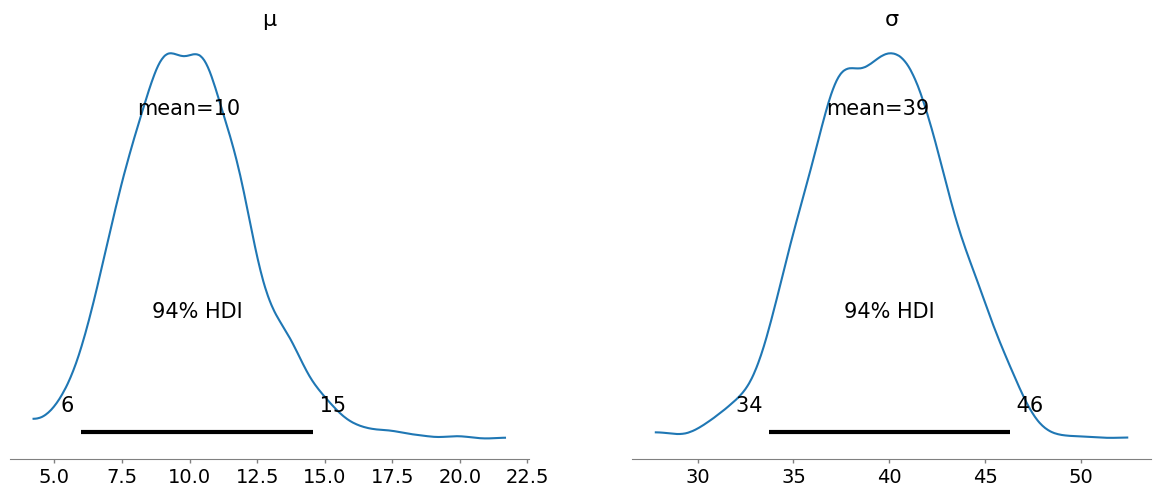

In [21]:
az.plot_posterior(igammaG)

In [25]:
pm.sample_posterior_predictive(igammaG, model=MidGoals, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

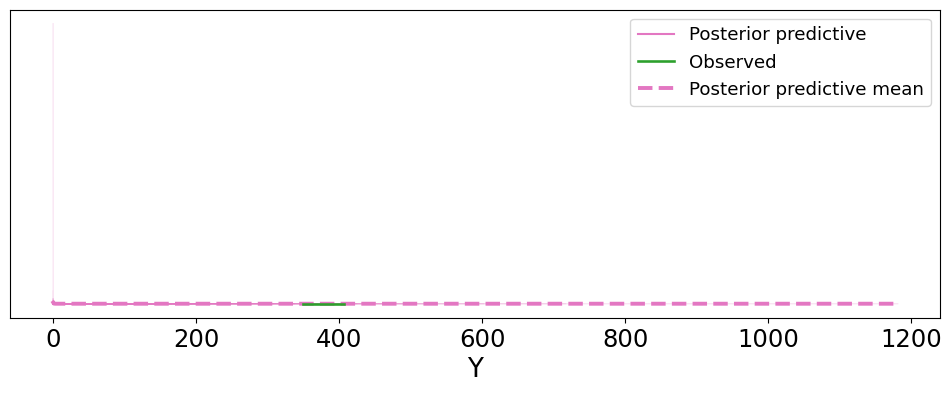

In [27]:
az.plot_ppc(igammaG, num_pp_samples=100, figsize=(12, 4), colors=["C16", "C2", "C16"])

I ran this model a few times and it didnt seem to give me anything, however i think its important to leave this in to show the differences in different model types. However, i believe Skew student will work best on my dataset, considering the skew i have.

In [51]:
#ST is for skew T
with pm.Model() as model_GoalST:
     # normal distribution for the mean
    μ = pm.Normal('μ', mu=430, sigma=6)

    #half normal distribution for standard deviation because the standard deviation is all positive and heavier near lower values
    σ = pm.HalfNormal('σ', sigma=3)

    #when a is larger than b, the dist. is positively skewed, when a is less its negative
    a = pm.HalfNormal('a', sigma=6)
    b = pm.HalfNormal('b', sigma=2)

    #SkewStudentR, which is the same as a T, except with more unusually high
    #or unusually low values.
    y = pm.SkewStudentT('y',mu=μ, sigma=σ, a = a, b = b, observed=MAGA)
    idataST = pm.sample()

Output()

Output()

Output()

(325.0, 415.0)

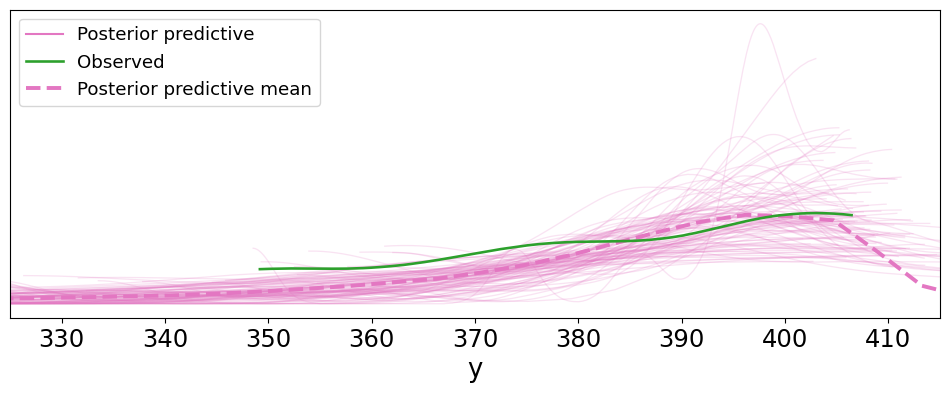

In [52]:
pm.sample_posterior_predictive(idataST, model=model_GoalST, extend_inferencedata=True)
ax = az.plot_ppc(idataST, num_pp_samples=100, figsize=(12, 4), colors=["C16", "C2", "C16"])
ax.set_xlim(325, 415)

I ran a lot of tests, and i think this one is the best fitting. Im pleased with the alignment of the peaks of my data and the Posterior predictive data. I do believ that with more tests ran, and changing the sigma values you will be abkee to align the left side a little bit more, but i believe this is pretty complete.